### Applied Time Series Analysis - Lab 3
Peter Woo

May 6, 2021



# Background

## Filters

In the context of data science, filters are generally used as a method to select a subset of the data based on set criteria for viewing or analytic purposes. Filtering can make analytic processes more convenient and/or effective, and is useful in a number of circumstances. For instance, it can be used to look at observation for a specified time period/groups of interest, refine erroneous or unwanted observations, or train and validate statistical models (Facer). 




### Examples of Filters 

#### Peirce's Criterion

Peirce's Criterion is an outlier filtering method that we have covered in the previous unit. This filter calculates the number of outliers that need to be removed in a dataset based on the characteristics of the observation data and the expected range of deviation of the observations. This filter, along with other common outlier filters, allows us to eliminate outliers for more accurate interpretation of statistics derived from the dataset.



#### `NA` Filters

It is very common for real world datasets to have gaps, or have observations with null values. There are a few ways to deal with these values, one of them being various gap-filling methods discussed in the previous unit. However, the simplest way to handle them is to eliminate these values/observations. One method we can use to do this is the `na.omit` function in R. 





In [ ]:
# Create a vector with an NA value in it
a <- c(1,2,3,NA)

# Use the function to filter out NA values 
b <- na.omit(a)

b

[1] 1 2 3
attr(,"na.action")
[1] 4
attr(,"class")
[1] "omit"

# Methods 

In this lab, I will be examining a popular internet meme soundbite that was a part of an interview in 2006. The Canadian sports media outlet *The Score* intereviewed then Anaheim Ducks' goaltender Ilya Bryzagalov, and asked a question regarding the return of his Ducks teammate Chris Pronger (Don, 2014). Bryzagalov replied with the now famous line: "It's only game. Why you have to be mad?" The interview was recorded 15 years ago, and therefore the sound quality is poor. With the help of some filters, this lab aims to eliminate background noise and make the recording clearer. 



## Importing the Data

This lab will use two R packages, `tuneR` and `tswge`

In [ ]:
install.packages('tuneR', dependencies = TRUE)
install.packages('tswge')

library('tuneR')
library('tswge')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘signal’, ‘pastecs’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘PolynomF’, ‘waveslim’, ‘astsa’




We can then read in the mp3 file with the following commands. 

In [18]:
mad.mp3 <- readMP3('/tmp/peterwoo_soundbite.mp3')

# Some summary statistics about our soundbite 
str(mad.mp3)

# Check for the length of the soundbite in seconds 
num_samples <- length(mad.mp3@left)
seconds <- num_samples / mad.mp3@samp.rate 

cat('\n', 'The sound file is', seconds, 'seconds long.')

Formal class 'Wave' [package "tuneR"] with 6 slots
  ..@ left     : int [1:198144] 0 0 0 0 0 0 0 0 0 0 ...
  ..@ right    : int [1:198144] 0 0 0 0 0 0 0 0 0 0 ...
  ..@ stereo   : logi TRUE
  ..@ samp.rate: num 44100
  ..@ bit      : num 16
  ..@ pcm      : logi TRUE

 The sound file is 4.493061 seconds long.

To reduce the amount of computing to be done, we will only use the left channel of the clip and covert the sound array to floating point values between 1 and -1. On top of that, we will only look at the first 50000 values. 

In [23]:
mono <- mad.mp3@left
reduced <- (mono / 2^(mad.mp3@bit - 1))

## Plotting the Data 

To plot the data, we need to first create an array with time points for the clip. 

In [24]:
# Create time point array
time <- (0:(num_samples - 1)) / mad.mp3@samp.rate

Then we can plot the sound file. 

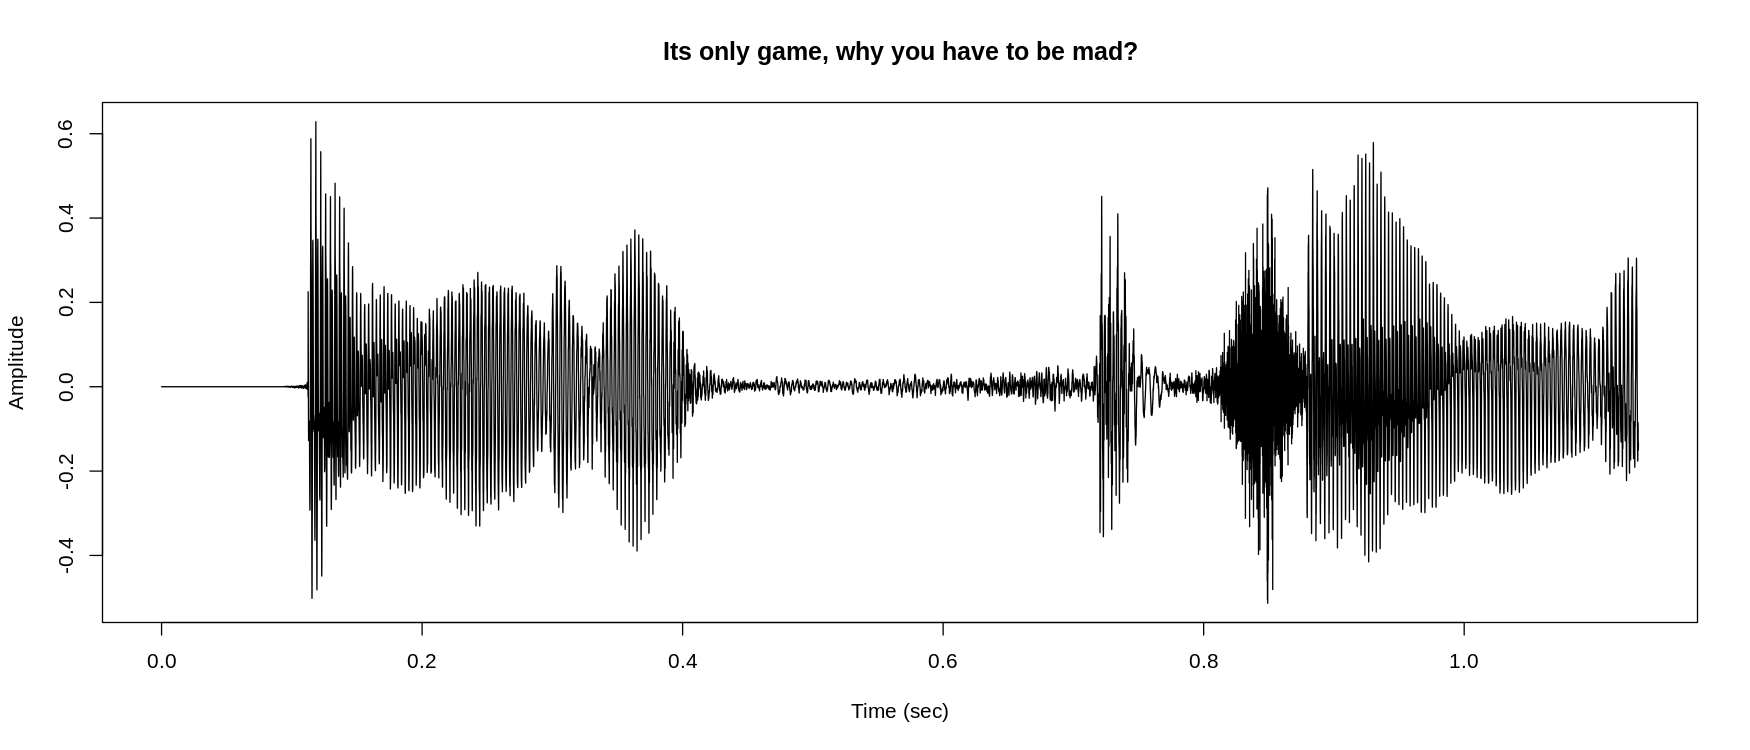

In [26]:
options(repr.plot.width=14, repr.plot.height=6, repr.plot.res = 125)
plot(time[1:50000], 
  reduced[1:50000],
  type='l', 
  col='black',
  main = 'Its only game, why you have to be mad?',  
  xlab='Time (sec)', 
  ylab='Amplitude')

## Filtering the Data 

Since we can hear some conversation in the background and other noises, we should be looking to filter low frequency sounds with a high-pass filter, as typical background noises are of the lower frequency variety (Davis, 2013). Additionally, we can use the low-pass filter to filter out any sibilance.

### High-pass filter

We can apply the high-pass filter to try and eliminate low frequency background noise. 

In [38]:
highp <- butterworth.wge(reduced, 4, type = 'high', cutoff = 0.01, plot = FALSE)

### Low-pass filter

We can apply the low-pass filter to eliminate high frequency noise. 

In [39]:
lowp <- butterworth.wge(reduced, 4, type = 'low', cutoff = 0.5, plot = FALSE )

# Results 

## Original Data 

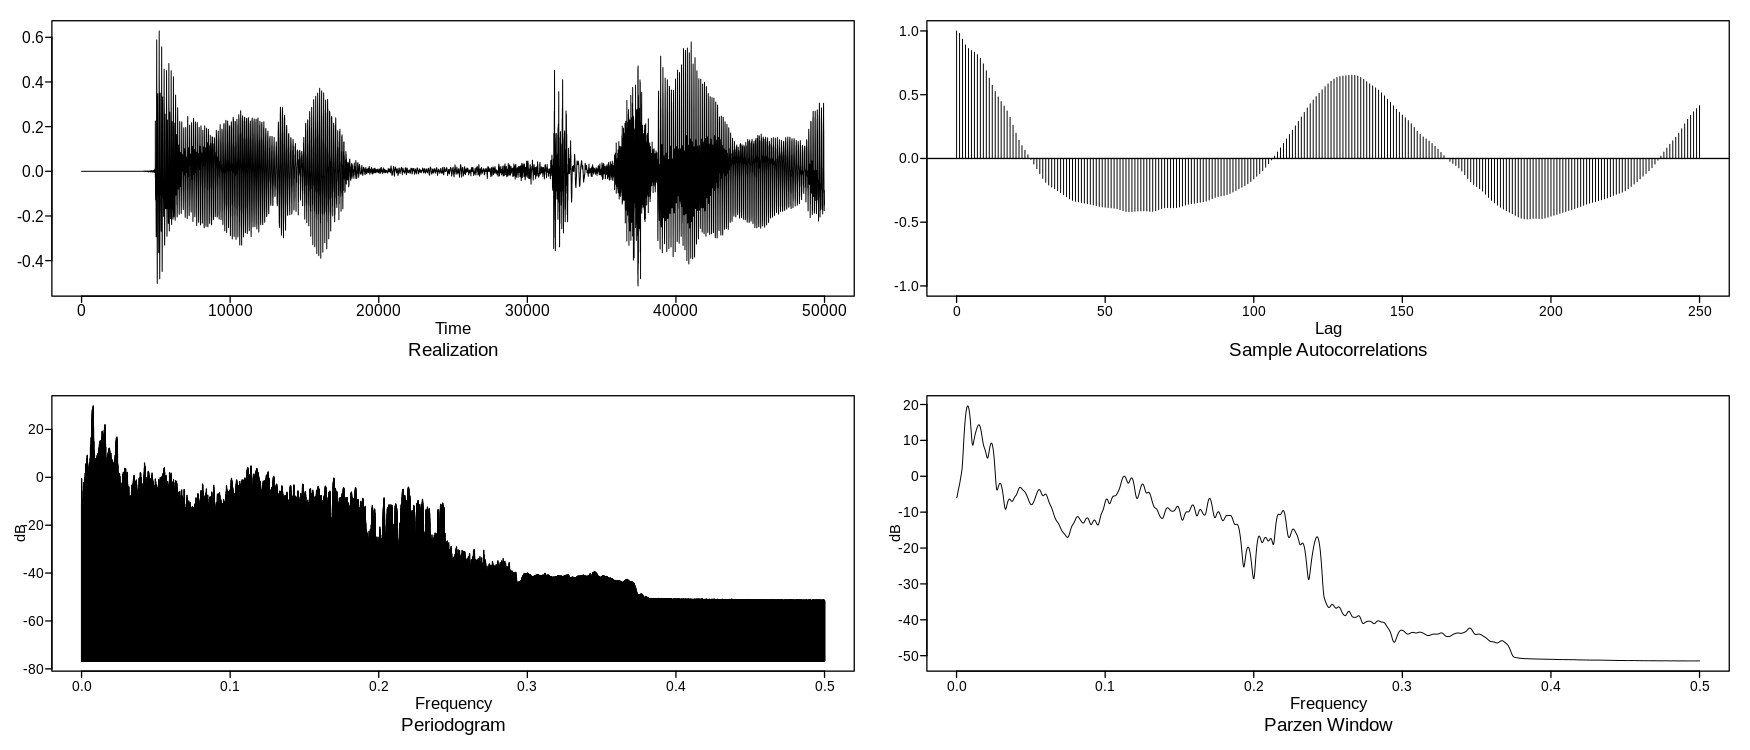

In [27]:
original <- plotts.sample.wge(reduced, lag.max = 250)

## High-pass

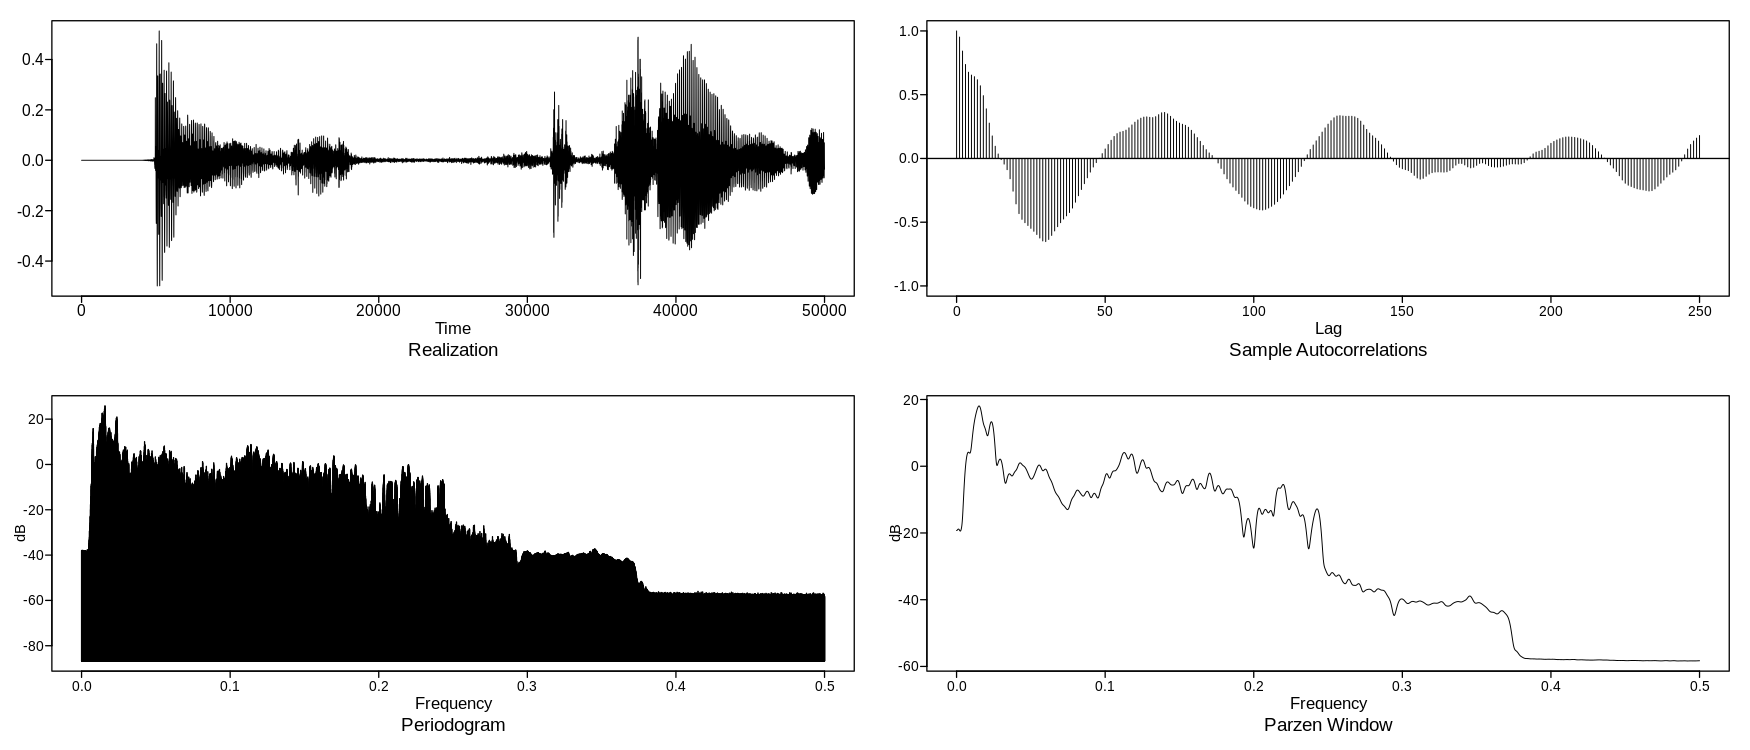

In [40]:
highpass <- plotts.sample.wge(highp$x.filt, lag.max = 250)

## Low-pass

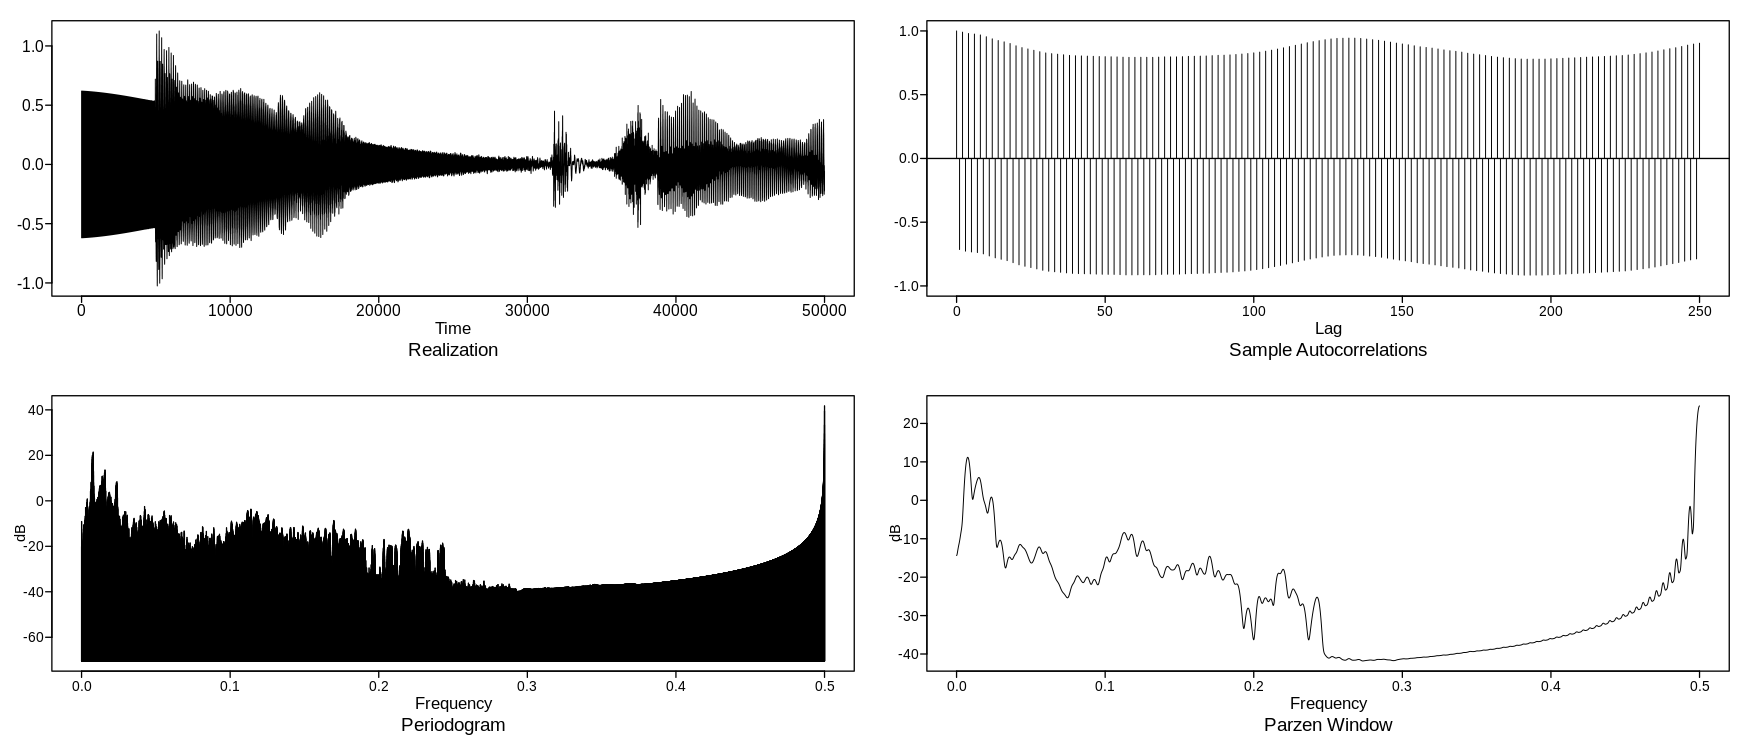

In [41]:
lowpass <- plotts.sample.wge(lowp$x.filt, lag.max = 250)

## Applying both filters simultaneously

To listen to what the filtered file with both the filters applied simultaneously would sound like, we can use a band pass filter. Since no plotting needs to be done in this process, We can look at the entire file and not just the first 50000 realizations. 

In [37]:
band_pass <- butterworth.wge(mono, 3, type = "pass", cutoff = c(0.01,0.5), plot = FALSE)
mad.filtered = Wave(band_pass$x.filt, samp.rate = 44100, bit = 16)
play(mad.filtered)
# Unsupported in Google Colab

# Discussion and Conclusion 

## Analyzing the plots

There wasn't any strong cyclical or periodic behavior apparent in any of the datasets. Upon examining the original dataset, we don't see any clear signs of periodicity or a prevailing dominant frequency. The periodogram demonstrates a peak very close to zero, and tapers off. 

Applying the high-pass filter did not result in a meaningful change. In fact, the periodograms are nearly identical. A dip or rise in the original periodogram can be tracked in the filtered periodogram. One difference we do see is in the autocorrelation plot. The sine-wave like behavior in the original autocorrelation plot still exists in the filtered one, but in the filtered periodogram we see it in a higher frequency. 

Applying the low-pass filter resulted in some interesting changes. First, in the plot of the realizations, we see a triangular shape in the beginning of the plot that tapers off as time progresses. This was not present in the original dataset. Second, the autocorrelation plot alternates from positive to negative repeatedly. Third, the periodogram now decreases then increases exponentially beginning from approximately 0.3. More research should be done to understand why the filter resulted in such changes. 

## Analyzing the filtered sound clip

Comparing the filtered sound clip to the original one, the first thing we notice is the change in volume. The filtered sound clip is much quieter than the original. Additionally, we don't hear the conversation that was previously present in the background. However, the quality of sound in the filtered clip feels more muffled. 

The next step for this lab would be to conduct further research on filtering techniques used in audio recording softwares, and find scientifically proven cutoff values to apply in the filters. For instance, sibilance, which happens when sibilant consonants (in English, "s", "z", "ch", "j" and "sh") are excessively prominent in recordings, takes place between 2-10 kHz depending on the voice of individuals (Wikipedia, 2021). Research along these lines can help produce a more effective filter with functional cutoff values to clean and restore older audio recordings. 

# References 


Davis, E. (2013, July 29). Influence of Background Noise on Hearing Test Results. https://www.ultimatekiosk.com/site/blog/2013/07/29/influence-of-background-noise-on-hearing-test-results-. 

Don. (2014). Why You Heff to be Mad? Know Your Meme. https://knowyourmeme.com/memes/why-you-heff-to-be-mad. 


Facer, C. (2020, December 9). What is Data Filtering? Displayr. https://www.displayr.com/what-is-data-filtering/#:~:text=Data%20filtering%20is%20the%20process,is%20used%20for%20the%20calculation.&amp;text=Exclude%20erroneous%20or%20%22bad%22%20observations%20from%20an%20analysis. 

Wikimedia Foundation. (2021, April 21). De-essing. Wikipedia. https://en.wikipedia.org/wiki/De-essing#:~:text=Sibilance%20lies%20in%20frequencies%20anywhere,depending%20on%20the%20individual%20voice. 